# Read data from .mat and plot FGM (mooring mean)

In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as sio
import io
import gsw

from dask.diagnostics import ProgressBar
from scipy import integrate
from matplotlib import cm


In [2]:
# load time-mean mooring data
data0 = sio.loadmat('/Users/tantanmeow/WORK/2018-2019/Jesse/TG/mooring_averages_processed.mat',squeeze_me = True,struct_as_record = False)
type(data0)
dict.keys(data0)

dict_keys(['__header__', '__version__', '__globals__', 'M5', 'P1', 'P3', 'P4', 'T1', 'T10', 'T11', 'T12', 'T2', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9'])

In [3]:
# build dataset
def dataset_dict(sample_dict, key):
    """build dataarray, coor = 'z'"""
    da_v = xr.DataArray(sample_dict[key].v, coords={"z": sample_dict[key].z,                                            
                                                   "site":key}, dims=["z"])
    da_sigma4 = xr.DataArray(sample_dict[key].sigma4, coords={"z": sample_dict[key].z,                                            
                                                   "site":key}, dims=["z"])
    da_hab = xr.DataArray(sample_dict[key].hab, coords={"z": sample_dict[key].hab,                                            
                                                   "site":key}, dims=["z"])

    ds = xr.Dataset({"v": (["z"], da_v),
                     "sigma4": (["z"], da_sigma4),
                     "hab": (["z"], da_hab)},
                    coords={"z": (["z"], da_v.z.data),
                            "site":key})

    return ds

In [4]:
# for key in data0.keys():
#     if len(key)<4:        
#         eval("key = dataset_dict(data0, key)")

In [5]:
# load FGM outputs from a .mat dataset 
data_path = '/Users/tantanmeow/WORK/2018-2019/Jesse/TG/'
data_name = 'TG_SI_mean_ex1.mat'
data = sio.loadmat(data_path + data_name,squeeze_me = True,struct_as_record = False)
type(data)
dict.keys(data)

dict_keys(['__header__', '__version__', '__globals__', 'EB_FGM', 'OT_FGM', 'WB_FGM'])

In [6]:
EB_FGM = data['EB_FGM'] ; WB_FGM = data['WB_FGM'] ; OT_FGM = data['OT_FGM'] ;

Plot site vs. growth rate, colorbar representing the number of zero-crossings

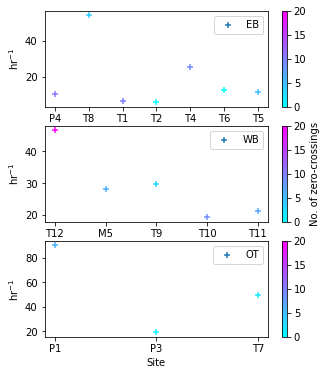

In [7]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(5, 6))
# EB
sc = ax[0].scatter(EB_FGM.site, 2*np.pi/EB_FGM.GR/3600, c=EB_FGM.I, marker='+', vmin=0, vmax=20, cmap=cm.cool, label="EB")
fig.colorbar(sc,label=" ",ax=ax[0])
# ax[0].set_xlabel("Site")
ax[0].set_ylabel("hr$^{-1}$")
ax[0].legend(loc='upper right')
# WB
sc = ax[1].scatter(WB_FGM.site, 2*np.pi/WB_FGM.GR/3600, c=WB_FGM.I, marker='+', vmin=0, vmax=20, cmap=cm.cool, label="WB")
fig.colorbar(sc,label="No. of zero-crossings",ax=ax[1])
# ax[1].set_xlabel("Site")
ax[1].set_ylabel("hr$^{-1}$")
ax[1].legend(loc='upper right')
# OT
sc = ax[-1].scatter(OT_FGM.site, 2*np.pi/OT_FGM.GR/3600, c=OT_FGM.I, marker='+', vmin=0, vmax=20, cmap=cm.cool, label="OT")
fig.colorbar(sc,label=" ",ax=ax[-1])
ax[-1].set_xlabel("Site")
ax[-1].set_ylabel("hr$^{-1}$")
ax[-1].legend(loc='upper right')

fig.savefig(data_path+data_name[:-4]+'_gr.png', dpi=300)

In [8]:
# plot insets 
def plot_insets(key, var, loc, xlim, ylim, ax):
    """plot insets, key = sites, variable = v (1) or n2 (2)"""
    self = ax.inset_axes(loc, transform=None, facecolor='none', frameon=False, sharey=None)
    self.set_yticks([]) , self.set_ylim(ylim) #, axin1.grid(True)
    self.set_xlim(xlim) , self.set_xticklabels([]) 
    self.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    if var == 1:
        self.plot([0, 0], [data0[key].z[0], data0[key].z[-1]],'.5')
        self.plot(data0[key].v, data0[key].z,'k')
    if var == 2:
        self.plot(np.log10(data0[key].n2), data0[key].zz,'k')


Plot site vs. critical level, colorbar representing the growth rate, black profiles show v

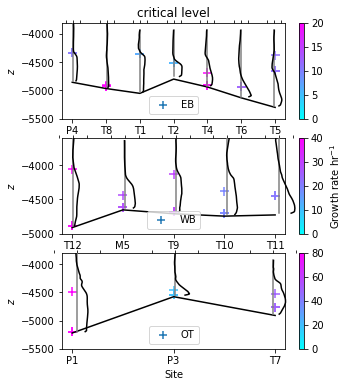

In [18]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(5, 6))
# EB
for i in range(len(EB_FGM.site)):
    plot_insets(EB_FGM.site[i], 1, [0+.15*i, 0, 0.1, 1], [-.4, .4], [-5500,-3800], ax[0])
ax[0].plot(EB_FGM.site, EB_FGM.bz,'k')
sc = ax[0].scatter(EB_FGM.site, EB_FGM.CL[:,0], c=2*np.pi/EB_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=20, cmap=cm.cool, label="EB")
for i in range(len(EB_FGM.CL[0,:])):
    ax[0].scatter(EB_FGM.site, EB_FGM.CL[:,i], c=2*np.pi/EB_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=20, cmap=cm.cool)
fig.colorbar(sc,label=" ",ax=ax[0])
ax[0].set_title("critical level")
# ax[0].set_xlabel("Site")
ax[0].set_ylabel("$z$")
# ax[0].set_ylim([-5500,-4200])
ax[0].set_ylim([-5500,-3800])
ax[0].legend(loc='lower center')

# WB
for i in range(len(WB_FGM.site)):
    plot_insets(WB_FGM.site[i], 1, [-.05+.23*i, 0, 0.2, 1], [-.4, .4], [-5000,-3600], ax[1])
ax[1].plot(WB_FGM.site, WB_FGM.bz,'k')
sc = ax[1].scatter(WB_FGM.site, WB_FGM.CL[:,0], c=2*np.pi/WB_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=40, cmap=cm.cool, label="WB")
for i in range(len(WB_FGM.CL[0,:])):
    ax[1].scatter(WB_FGM.site, WB_FGM.CL[:,i], c=2*np.pi/WB_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=40, cmap=cm.cool)
fig.colorbar(sc,label="Growth rate hr$^{-1}$",ax=ax[1])
# ax[1].set_xlabel("Site")
ax[1].set_ylabel("$z$")
# ax[1].set_ylim([-5000,-4000])
ax[1].set_ylim([-5000,-3600])
ax[1].legend(loc='lower center')

# OT
for i in range(len(OT_FGM.site)):
    plot_insets(OT_FGM.site[i], 1, [-.1+.44*i, 0, 0.33, 1], [-.4, .4], [-5500,-3800], ax[-1])
ax[-1].plot(OT_FGM.site, OT_FGM.bz,'k')
sc = ax[-1].scatter(OT_FGM.site, OT_FGM.CL[:,0], c=2*np.pi/OT_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=80, cmap=cm.cool, label="OT")
for i in range(len(OT_FGM.CL[0,:])):
    ax[-1].scatter(OT_FGM.site, OT_FGM.CL[:,i], c=2*np.pi/OT_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=80, cmap=cm.cool)
fig.colorbar(sc,label=" ",ax=ax[-1])
ax[-1].set_xlabel("Site")
ax[-1].set_ylabel("$z$")
# ax[-1].set_ylim([-5500,-4200])
ax[-1].set_ylim([-5500,-3800])
ax[-1].legend(loc='lower center')

# fig.savefig(data_path+data_name[:-4]+'_cl_v.png', dpi=300)

Plot site vs. critical level, colorbar representing the growth rate, black profiles show $N^2$

/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


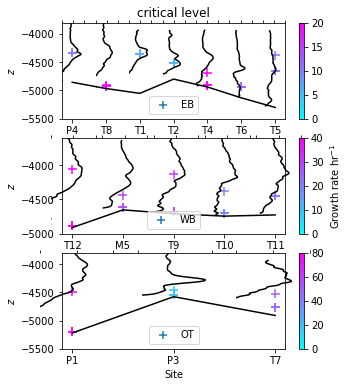

In [19]:
fig, ax =  plt.subplots(nrows=3, ncols=1, figsize=(5, 6))
# EB
for i in range(len(EB_FGM.site)):
    plot_insets(EB_FGM.site[i], 2, [0+.15*i, 0, 0.1, 1], [-7, -5], [-5500,-3800], ax[0])
ax[0].plot(EB_FGM.site, EB_FGM.bz,'k')
sc = ax[0].scatter(EB_FGM.site, EB_FGM.CL[:,0], c=2*np.pi/EB_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=20, cmap=cm.cool, label="EB")
for i in range(len(EB_FGM.CL[0,:])):
    ax[0].scatter(EB_FGM.site, EB_FGM.CL[:,i], c=2*np.pi/EB_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=20, cmap=cm.cool)
fig.colorbar(sc,label=" ",ax=ax[0])
ax[0].set_title("critical level")
# ax[0].set_xlabel("Site")
ax[0].set_ylabel("$z$")
# ax[0].set_ylim([-5500,-4200])
ax[0].set_ylim([-5500,-3800])
ax[0].legend(loc='lower center')

# WB
for i in range(len(WB_FGM.site)):
    plot_insets(WB_FGM.site[i], 2, [-.05+.23*i, 0, 0.2, 1], [-7, -5], [-5000,-3600], ax[1])
ax[1].plot(WB_FGM.site, WB_FGM.bz,'k')
sc = ax[1].scatter(WB_FGM.site, WB_FGM.CL[:,0], c=2*np.pi/WB_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=40, cmap=cm.cool, label="WB")
for i in range(len(WB_FGM.CL[0,:])):
    ax[1].scatter(WB_FGM.site, WB_FGM.CL[:,i], c=2*np.pi/WB_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=40, cmap=cm.cool)
fig.colorbar(sc,label="Growth rate hr$^{-1}$",ax=ax[1])
# ax[1].set_xlabel("Site")
ax[1].set_ylabel("$z$")
ax[1].set_ylim([-5000,-3600])
# ax[1].set_ylim([-5000,-4000])
ax[1].legend(loc='lower center')

# OT
for i in range(len(OT_FGM.site)):
    plot_insets(OT_FGM.site[i], 2, [-.1+.44*i, 0, 0.33, 1], [-7, -5], [-5500,-3800], ax[-1])
ax[-1].plot(OT_FGM.site, OT_FGM.bz,'k')
sc = ax[-1].scatter(OT_FGM.site, OT_FGM.CL[:,0], c=2*np.pi/OT_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=80, cmap=cm.cool, label="OT")
for i in range(len(OT_FGM.CL[0,:])):
    ax[-1].scatter(OT_FGM.site, OT_FGM.CL[:,i], c=2*np.pi/OT_FGM.GR/3600, marker='+', s=80, vmin=0, vmax=80, cmap=cm.cool)
fig.colorbar(sc,label=" ",ax=ax[-1])
ax[-1].set_xlabel("Site")
ax[-1].set_ylabel("$z$")
# ax[-1].set_ylim([-5500,-4200])
ax[-1].set_ylim([-5500,-3800])
ax[-1].legend(loc='lower center')

# fig.savefig(data_path+data_name[:-4]+'_cl_n2.png', dpi=300)

Unstable modes seem to grow very rapidly with critical levels located near the interface of overflow at T1 and T2 (slightly upstream of sill?). 

Mooring T1:

Growh rates of the fastest growing mode for different k and the Howard's semicircle:

![T1 Wave modes](/Users/tantanmeow/WORK/2018-2019/Jesse/TG/TG_SI_mean/TG_SI_mean_ex1_T1_1.jpg)

Amplitude and phase (a shift of about $70^\circ$) of the fastest growing mode, star represents the critical level:

![T1 Wave modes](/Users/tantanmeow/WORK/2018-2019/Jesse/TG/TG_SI_mean/TG_SI_mean_ex1_T1_2.jpg)

Mooring T2:

Growh rates of the fastest growing mode for different k and the Howard's semicircle:

![T2 Wave modes](/Users/tantanmeow/WORK/2018-2019/Jesse/TG/TG_SI_mean/TG_SI_mean_ex1_T2_1.jpg)

Amplitude and phase (a shift of about $60^\circ$) of the fastest growing mode, star represents the critical level:

![T2 Wave modes](/Users/tantanmeow/WORK/2018-2019/Jesse/TG/TG_SI_mean/TG_SI_mean_ex1_T2_2.jpg)


# Read data from .mat and plot FGM (tow-yoo snapshot)

Raw profiles (snapshots) have many overturns and cause violet-shift of the growth rate, suggesting convective instability. I tried to exclude these overturns but found the minimum Ri is typically larger than 1/4... 

In [15]:
6e-4*1000/(2e-5*1.2e+5)

0.24999999999999994